## Project Model

### 1. Import Necessary Libraries

In [28]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1_l2
import matplotlib.pyplot as plt

### 2. Data Importing and Cleaning

In [16]:
directory = '/Users/yunzheyu/Desktop/DS340/Project/DataSets'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

cleaned_data = []  # This will store all the cleaned DataFrames to be combined later

for file in csv_files:
    file_path = os.path.join(directory, file)
    
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Filter to include only rows where the Event column is 'SBD' and Equipment is 'Raw'
    sbd_raw_data = data[(data['Event'] == 'SBD') & (data['Equipment'] == 'Raw')]
    
    # Drop specified columns
    columns_to_drop = [
        'AgeClass', 'BirthYearClass', 'WeightClassKg', 'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
        'Wilks', 'Glossbrenner', 'Goodlift', 'Country', 'State', 'MeetCountry', 
        'MeetState', 'MeetTown', 'Federation', 'ParentFederation', 'MeetName'
    ]
    sbd_raw_data = sbd_raw_data.drop(columns=columns_to_drop, errors='ignore')
    
    # Drop rows where the Place column contains 'DQ', 'NS', or 'G'
    sbd_raw_data = sbd_raw_data[~sbd_raw_data['Place'].isin(['DQ', 'NS', 'G'])]

    # Drop rows where the Tested column is empty
    sbd_raw_data = sbd_raw_data.dropna(subset=['Tested'])
    
    # Save the cleaned data to a new CSV file
    cleaned_file_path = os.path.join(directory, f'cleaned_{file}')
    sbd_raw_data.to_csv(cleaned_file_path, index=False)
    
    # Append the cleaned data to the list for later combination
    cleaned_data.append(sbd_raw_data)

# Concatenate all data into a single DataFrame
combined_cleaned_data = pd.concat(cleaned_data, ignore_index=True)
combined_cleaned_data.to_csv('combined_cleaned_data.csv', index=False)

### 2.1 Dealing with missing age.

Some Atheletes do have provide their ages. So, we will use the last known competition date and last known age to estimate the missing age value

In [17]:
data = pd.read_csv('combined_cleaned_data.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Sort data by athlete's name and date of competition
data.sort_values(by=['Name', 'Date'], inplace=True)

def fill_missing_ages(group):
    # Forward fill the missing age values within each group
    group['Age'] = group['Age'].ffill()
    
    # Mark the filled ages as estimated by adding a tilde (~)
    group['Age'] = group['Age'].apply(lambda x: f"~{x}" if pd.isnull(x) else x)
    
    return group

# Apply the function to each group of athlete's data and overwrite the 'Age' column
data = data.groupby('Name').apply(fill_missing_ages)

# Save the modified DataFrame back to CSV or continue processing
data.to_csv('modified_combined_cleaned_data.csv', index=False)


### 3. Features Engineering

In [18]:
data = pd.read_csv('modified_combined_cleaned_data.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Add a 'Year' column for the year of the competition
data['Year'] = data['Date'].dt.year

# 1. Competition Frequency
# Calculate the number of competitions each athlete has participated in
data['CompetitionFrequency'] = data.groupby('Name')['Date'].transform('count')

# 2. Year-over-Year Performance Improvements
# First, calculate the max 'TotalKg' for each athlete each year
data['MaxTotalKg'] = data.groupby(['Name', 'Year'])['TotalKg'].transform('max')

# Then, calculate the year-over-year improvement for each athlete
# Shift the 'MaxTotalKg' within each group to get the previous year's max total
data['PreviousMaxTotalKg'] = data.groupby('Name')['MaxTotalKg'].shift(1)

# The improvement is the current year's max total minus the previous year's
data['YoYPerformanceImprovement'] = data['MaxTotalKg'] - data['PreviousMaxTotalKg']

# Note: The first entry for each athlete will have NaN for 'YoYPerformanceImprovement'
# because there is no previous year's data to compare to

# 3. Athlete's Age
data['Age'] = data['Age'].astype(str).str.replace('~', '').astype(float)

# Save the dataframe with the new features to a new CSV file
data.to_csv('feature_engineered_data.csv', index=False)


### 4. Model Development

Due to the nature of the data, complex model is not appropriate. I will stick with a simple model.

In [27]:
df = pd.read_csv('feature_engineered_data.csv')


# Sort by athlete and date to maintain the sequence
df.sort_values(by=['Name', 'Date'], inplace=True)

# Keep only athletes with more than 10 records
athlete_counts = df['Name'].value_counts()
df = df[df['Name'].isin(athlete_counts[athlete_counts > 10].index)]

# Normalize the 'TotalKg' feature
scaler = StandardScaler()
df['TotalKg'] = scaler.fit_transform(df[['TotalKg']])

# A more complex sequence creation function, using more time steps
def create_sequences(data, sequence_length):
    xs, ys = [], []
    data_array = data.to_numpy()
    for i in range(len(data_array) - sequence_length):
        xs.append(data_array[i:(i + sequence_length)])
        ys.append(data_array[i + sequence_length])
    return np.array(xs), np.array(ys)

# Try using a sequence_length greater than 1 to provide the model with more context
sequence_length = 5  # For example, look back 5 time steps
sequences, labels = create_sequences(df['TotalKg'], sequence_length=sequence_length)
X = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
y = labels.reshape(-1, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a more complex LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model, allow for potentially longer training time
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")



Epoch 1/50
17/17 [==============================] - 4s 132ms/step - loss: 0.8268 - val_loss: 0.4863
Epoch 2/50
17/17 [==============================] - 2s 96ms/step - loss: 0.5305 - val_loss: 0.1768
Epoch 3/50
17/17 [==============================] - 2s 104ms/step - loss: 0.4117 - val_loss: 0.1490
Epoch 4/50
17/17 [==============================] - 1s 88ms/step - loss: 0.4075 - val_loss: 0.1358
Epoch 5/50
17/17 [==============================] - 2s 90ms/step - loss: 0.3757 - val_loss: 0.1143
Epoch 6/50
17/17 [==============================] - 1s 87ms/step - loss: 0.3515 - val_loss: 0.0784
Epoch 7/50
17/17 [==============================] - 1s 87ms/step - loss: 0.3215 - val_loss: 0.0797
Epoch 8/50
17/17 [==============================] - 1s 88ms/step - loss: 0.3397 - val_loss: 0.0595
Epoch 9/50
17/17 [==============================] - 1s 87ms/step - loss: 0.3211 - val_loss: 0.0978
Epoch 10/50
17/17 [==============================] - 1s 87ms/step - loss: 0.3059 - val_loss: 0.0461
Epoch 1

## 5. Showing Results

3/3 [==============================] - 0s 59ms/step


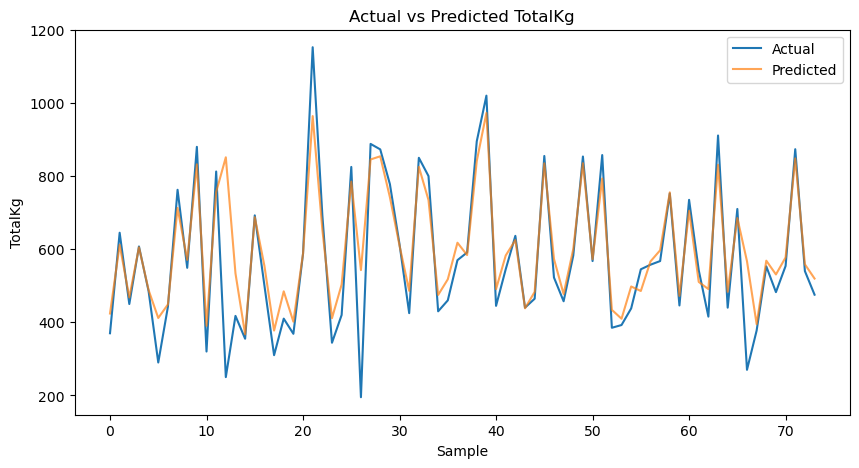

In [29]:
# Predict using the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values if they were scaled
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot actual vs predicted performances
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted TotalKg')
plt.xlabel('Sample')
plt.ylabel('TotalKg')
plt.legend()
plt.show()